# Predictiong biochemical activity against 2c9 with a small dataset

In this notebook we will try to use the more representative features of the MACCS fingerprint and the physicochemical descriptors given by Mordred library to fit a model with small dataset.


## Overview

- Load data
- Get fingerprint (in this case we simply load it from files)
- Get descriptors
    - Remove outliers and Normalise data
- Split the data (500 molecules Train + Validation)
- Select data with mutual information score
- DNN
    - Hyperparameters tunning

## 1) Packages

In [25]:
%matplotlib inline
%load_ext tensorboard
!rm -rf ./logs/ 

import os
import random
import numpy as np
import numpy.testing as npt 
import pandas as pd
import collections
import tensorflow as tf
from scipy import stats
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from itertools import product
from sklearn.utils.class_weight import compute_class_weight
from sklearn.svm import SVC
from sklearn.metrics import auc, roc_curve, f1_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize #, minmax_scale it could also be tried.
from sklearn.feature_selection import SelectPercentile, SelectKBest
from sklearn.feature_selection import chi2, mutual_info_classif
from sklearn.model_selection import StratifiedKFold
from tensorboard.plugins.hparams import api as hp
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from rdkit import Chem
from mordred import Calculator, descriptors

plt.style.use("ggplot")
matplotlib.rcParams.update({'font.size': 24})
PATH_DATA = "../datasets/CYP/"
print(tf.__version__)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
2.0.0


## 2) Loading data

In [2]:
PATH_DATA = "../datasets/CYP/"

shared_data = pd.read_csv(os.path.join(PATH_DATA, "shared_set_cyp.csv"))
labels_2c9 = (shared_data["p450-cyp2c9 Activity Outcome"] == "Active").values.astype(int)
labels_3a4 = (shared_data["p450-cyp3a4 Activity Outcome"] == "Active").values.astype(int)
testing_2c9_data = pd.read_csv(os.path.join(PATH_DATA, "only_2c9_set_cyp.csv"))
labels_testing_2c9 = (testing_2c9_data["p450-cyp2c9 Activity Outcome"] == "Active").values.astype(int)
testing_3a4_data = pd.read_csv(os.path.join(PATH_DATA, "only_3a4_set_cyp.csv"))
labels_testing_3a4 = (testing_3a4_data["p450-cyp3a4 Activity Outcome"] == "Active").values.astype(int)

In [3]:
def col_to_array(df, col_name='p450-cyp2c9 Activity Outcome'):
    col = df[col_name]
    arr = col.to_numpy() # class wants to make reference to active or inactive
    arr = np.reshape(arr, [arr.shape[0],1])
    return np.squeeze(arr)

In [4]:
smi_col_shared = col_to_array(shared_data, 'CanonicalSMILES')
smi_col_only2c9 = col_to_array(testing_2c9_data, 'CanonicalSMILES')

## 3) Get features (RDKit fingerprint)

We need to generate the features for the data sets, we will use RDKit fingerprints as implemented in RDKit.

In [5]:
def get_features(input_sdf):
    structures_shared = Chem.SDMolSupplier(input_sdf)
    features = []
    for mol in structures_shared:
        fp = Chem.RDKFingerprint(mol)
        arr = np.zeros((0,), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(fp,arr)
        features.append(arr)
    return np.array(features)

In [6]:
if os.path.exists(os.path.join("features", "shared_set_features_RDKIT.npy")):
    features_shared = np.load(os.path.join("features", "shared_set_features_RDKIT.npy"))
else:
    features_shared = get_features(os.path.join(PATH_DATA, "shared_set_cyp.sdf"))
    np.save(os.path.join("features", "shared_set_features_RDKIT.npy"), features_shared)
    
if os.path.exists(os.path.join("features", "only_2c9_set_features_RDKIT.npy")):
    features_only_2c9 = np.load(os.path.join("features", "only_2c9_set_features_RDKIT.npy"))
else:   
    features_only_2c9 = get_features(os.path.join(PATH_DATA, "only_2c9_set_cyp.sdf"))
    np.save(os.path.join("features", "only_2c9_set_features_RDKIT.npy"), features_only_2c9)
    
if os.path.exists(os.path.join("features", "only_3a4_set_features_RDKIT.npy")):
    features_only_3a4 = np.load(os.path.join("features", "only_3a4_set_features_RDKIT.npy"))
else:   
    features_only_3a4 = get_features(os.path.join(PATH_DATA, "only_3a4_set_cyp.sdf"))
    np.save(os.path.join("features", "only_3a4_set_features_RDKIT.npy"), features_only_3a4)

## 4) Getting Mordred descriptors

We generate the descriptors using Mordred if ther are not in the features folder, otherwise the data is loaded from there.

There are two types of data we can load:

- Data without processing: this contains all the physicochemical descriptors that are generated with Mordred.
- Clean data: this data doesn't contains all the descriptors computed by Mordred. All the columns wich contain NaN, are remove to easily apply the feature selection.
    - This data has been processed as follows:
        - Convert all the str in the data frame to NaN.
        - Remove columns that contain NaN values.
            - Note that if we remove rows, we obtain an empty df (-> everything is removed)
        - Remove all the columns with different headers between the shared and only 2c9 datasets.
- Detection and remove of Outliers
- Normalisation

In [7]:
load_clean_data =  True # Otherwise it will load data with NaN
remove_outliers = True
normalize_descriptors = True

In [8]:
def get_descriptors(smi_arr, activity_labels, clean_dataset=True, save_to_npy=True, filename='shared_set_features_mordred'):
    calc = Calculator(descriptors, ignore_3D=True)
    mols = [Chem.MolFromSmiles(smi) for smi in smi_arr]
    df_descriptors = calc.pandas(mols)
    df_descriptors = df_descriptors.insert(0, "p450-cyp2c9 Activity Outcome", activity_labels, True)
    if clean_dataset:
        df_descriptors = descriptors_shared.apply(pd.to_numeric, errors='coerce')
        df_descriptors = df_descriptors.dropna(axis=1)
    if save_to_npy:
        df_descriptors.to_csv(os.path.join("features", filename + ".npy"))
    return df_descriptors

In [9]:
if load_clean_data:
    if os.path.exists(os.path.join("features", "shared_set_features_mordred_clean.npy")):
        descriptors_shared = pd.read_csv(os.path.join("features", "shared_set_features_mordred_clean.npy")).drop(['Unnamed: 0'], axis=1)
    else:
        descriptors_shared = get_descriptors(smi_col_shared, labels_2c9, clean_dataset=True, filename='shared_set_features_mordred_clean')

    if os.path.exists(os.path.join("features", "only2c9_features_mordred_clean.npy")):
        descriptors_only2c9 = pd.read_csv(os.path.join("features", "only2c9_features_mordred_clean.npy")).drop(['Unnamed: 0'], axis=1)
    else:
        descriptors_only2c9 = get_descriptors(smi_col_only2c9, labels_testing_2c9, clean_dataset=True, filename='only2c9_features_mordred_clean')

else:
    if os.path.exists(os.path.join("features", "shared_set_features_mordred.npy")):
        descriptors_shared = pd.read_csv(os.path.join("features", "shared_set_features_mordred.npy")).drop(['Unnamed: 0'], axis=1)
    else:
        descriptors_shared = get_descriptors(smi_col_shared, labels_2c9, clean_dataset=False, filename='shared_set_features_mordred')

    if os.path.exists(os.path.join("features", "only2c9_features_mordred.npy")):
        descriptors_only2c9 = pd.read_csv(os.path.join("features", "only2c9_features_mordred.npy")).drop(['Unnamed: 0'], axis=1)
    else:
        descriptors_only2c9 = get_descriptors(smi_col_only2c9, labels_testing_2c9, clean_dataset=False, filename='only2c9_features_mordred')

In [10]:
if load_clean_data: # To get data with the same descriptors
    lst_shared_clean=list(descriptors_shared.columns.values)
    lst_only2c9_clean=list(descriptors_only2c9.columns.values)
    common_elements=list(set(lst_shared_clean) & set(lst_only2c9_clean))

    lst_shared_clean = list(set(lst_shared_clean)-set(common_elements))
    lst_only2c9_clean = list(set(lst_only2c9_clean)-set(common_elements))
    
    descriptors_shared = descriptors_shared.drop(lst_shared_clean, axis=1)
    descriptors_only2c9 = descriptors_only2c9.drop(lst_only2c9_clean, axis=1)
    
assert descriptors_shared.shape[1] == descriptors_only2c9.shape[1]

In [11]:
print(descriptors_shared.shape, descriptors_only2c9.shape)

(9420, 752) (2813, 752)


### 4.1) Detection and remove of Outliers

Before selecting features, we will remove the examples that contain outliers using the Z score criteria.

$Z = \frac{X-\mu}{\sigma}$

Z-scores can quantify the unusualness of an observation when your data follow the normal distribution. Z-scores are the number of standard deviations above and below the mean that each value falls. For example, a Z-score of 2 indicates that an observation is two standard deviations above the average while a Z-score of -2 signifies it is two standard deviations below the mean. A Z-score of zero represents a value that equals the mean. [Source](https://statisticsbyjim.com/basics/outliers/)

In [12]:
def compute_z_score(df_original):
    df=df_original.copy()
    headers = []
    for col in df.columns:
        df[f'{col}_zscore'] = (df[col] - df[col].mean())/df[col].std(ddof=0)
        headers.append(col)
    return df, headers

def outliers_detection(df, threshold=3):
    df_scored, headers=compute_z_score(df)
    zscore_col = list(set(df_scored.columns) - set(headers)) # to only evaluate zscore columns
    for col in zscore_col:
        df_scored[f'{col}_outlier'] = (abs(df_scored[f'{col}'])> threshold).astype(int)
    return df_scored, zscore_col

def drop_outliers(df, threshold=3):
    df_outlier, zscore_col = outliers_detection(df, threshold=threshold)
    for col in zscore_col:
        index = df_outlier[ df_outlier[f'{col}_outlier'] == 1 ].index
        df_outlier.drop(index , inplace=True)
        df_outlier.drop(col , inplace=True,axis = 1)
        df_outlier.drop(f'{col}_outlier' , inplace=True, axis = 1)
    return df_outlier

Note that in this cell we remove the molecules which contain descriptors' outliers in the fingerprint dataset.

In [13]:
if remove_outliers:
    threshold = 3
    if not os.path.exists(os.path.join("features", "shared_set_features_mordred_clean_no_outliers.npy")):
        descriptors_shared = drop_outliers(descriptors_shared, threshold=threshold)
        descriptors_shared.to_csv(os.path.join("features", 'shared_set_features_mordred_clean_no_outliers.npy'))   
    descriptors_shared = pd.read_csv(os.path.join("features", "shared_set_features_mordred_clean_no_outliers.npy"))
    loc = list(descriptors_shared['Unnamed: 0'])
    features_shared = features_shared[loc,:]
    descriptors_shared = descriptors_shared.drop(['Unnamed: 0'], axis=1)
  
    if not os.path.exists(os.path.join("features", "only2c9_features_mordred_clean_no_outliers.npy")):
        descriptors_only2c9 = drop_outliers(descriptors_only2c9, threshold=threshold)
        descriptors_only2c9.to_csv(os.path.join("features", 'only2c9_features_mordred_clean_no_outliers.npy'))
    descriptors_only2c9 = pd.read_csv(os.path.join("features", "only2c9_features_mordred_clean_no_outliers.npy"))
    loc = list(descriptors_only2c9['Unnamed: 0'])
    features_only_2c9 = features_only_2c9[loc,:]
    descriptors_only2c9 = descriptors_only2c9.drop(['Unnamed: 0'], axis=1)
    
assert descriptors_shared.shape[1] == descriptors_only2c9.shape[1]

In [14]:
descriptors_shared.shape, descriptors_only2c9.shape

((2372, 752), (846, 752))

In [15]:
if remove_outliers and not descriptors_only2c9.shape[1] == descriptors_shared.shape[1]:
    lst_shared_clean=list(descriptors_shared.columns.values)
    lst_only2c9_clean=list(descriptors_only2c9.columns.values)
    common_elements=list(set(lst_shared_clean) & set(lst_only2c9_clean))

    lst_shared_clean = list(set(lst_shared_clean)-set(common_elements))
    lst_only2c9_clean = list(set(lst_only2c9_clean)-set(common_elements))
    
    descriptors_shared = descriptors_shared.drop(lst_shared_clean, axis=1)
    descriptors_only2c9 = descriptors_only2c9.drop(lst_only2c9_clean, axis=1)
    
    descriptors_shared.to_csv(os.path.join("features", 'shared_set_features_mordred_clean_no_outliers.npy'))
    descriptors_only2c9.to_csv(os.path.join("features", 'only2c9_features_mordred_clean_no_outliers.npy'))
    
    labels_2c9 = np.array(descriptors_shared['p450-cyp2c9 Activity Outcome'])
    labels_testing_2c9 = np.array(descriptors_only2c9['p450-cyp2c9 Activity Outcome'])

    
labels_2c9 = np.array(descriptors_shared['p450-cyp2c9 Activity Outcome'])
labels_testing_2c9 = np.array(descriptors_only2c9['p450-cyp2c9 Activity Outcome'])

assert descriptors_shared.shape[0] == labels_2c9.shape[0]
assert descriptors_only2c9.shape[0] == labels_testing_2c9.shape[0]
assert descriptors_shared.shape[1] == descriptors_only2c9.shape[1]

In [16]:
descriptors_shared.shape, descriptors_only2c9.shape

((2372, 752), (846, 752))

### 4.2) Normalisation

Now we are going to normalise each feature of the dataset to values between [0,1]

In [17]:
norm_descriptors_shared = pd.DataFrame(normalize(descriptors_shared, norm='max', axis=0))
norm_descriptors_only2c9 = pd.DataFrame(normalize(descriptors_only2c9, norm='max', axis=0))

## 5) Feature selection and cross validation

In this part we want to select the descriptors and the fingerprint features that are very representative of the molecule activity.
However, as we want to simulate what happens in a small dataset, the best features will be selected with the training set after splitting the data.
The training set will consist in a small dataset.

Here we propose two ways in how it can be done the feature selection and the cross validation:

### A)

In this case, for each train/val split, we're going to find the best parameters and, subsequently, carry out the validation of the model.

- Generate 15 random numbers that are going to be used as seeds for the splitting of the train/val datasets.
    - It is important to save this random numbers, because they are going to be used for the cross validation.
- Split the train and validation set many times (15 times) to reduce the possibiity of having a wierd split.
    - Selection of the best features for each split, and save them.
    - Fit and predict on the validation (CV).
- Select the most important features (i.e. the more repeated) using the best features we collect when splitting.
- With the most important features, fit the model (with all the train + validation set) and predict on the test set.

### B)

In this case, we'll find the features that are useful for each split and then, select the ones that are more relevant. 
With the most relevant features, we'll do the cross validation

#### B1) Best features selection
- Generate 15 random numbers that are going to be used as seeds for the splitting of the train/val datasets.
    - It is important to save this random numbers, because they are going to be used for the cross validation.
- Split the train and validation set many times (15 times) to reduce the possibiity of having a wierd split.
    - Selection of the best features for each split.
- Select the best features considering the best features for each split
    - To do so, we'll use a consensus function (most repeated).

#### B2) Validation model with the best features


#### B3) Predicction

In the following cell there are the percentage of values that are kept of the descriptors.
Since the fingerprint seems to have a low score in all its features (see plots below), a lower percentil was selected in order to avoid 'noise'.

In [18]:
# Percentage to be kept
percetile_descriptors = 60
percetile_fingerprint = 60 #40

use_fingerprints = True # if true -> fingerpornts are used.
use_descriptors = True # if true -> descriptors are used.

if use_fingerprints and not use_descriptors:
    print("Only fingerprints are going to be used.")
elif use_descriptors and not use_fingerprints:     
    print("Only descriptors are going to be used.")
elif use_fingerprints and use_descriptors:
    print("Fingerprints and descriptors are going to be used (concatenated).")

Fingerprints and descriptors are going to be used (concatenated).


In [19]:
# Drop the first column which contain the chemical activity against 2c9
norm_descriptors_shared = norm_descriptors_shared.drop([0], axis=1)
norm_descriptors_only2c9 = norm_descriptors_only2c9.drop([0], axis=1)
                                                       
assert features_shared.shape[0] == norm_descriptors_shared.shape[0]
assert features_only_2c9.shape[0] == norm_descriptors_only2c9.shape[0]

In [20]:
train_data = np.asarray(train_data).astype(np.float32)
val_data = np.asarray(val_data).astype(np.float32)

NameError: name 'train_data' is not defined

In [85]:
norm_descriptors_shared = np.asarray(norm_descriptors_shared).astype(np.float32) # to avoid problems with the KFoldCrossValidation
norm_descriptors_only2c9 = np.asarray(norm_descriptors_only2c9).astype(np.float32) # to avoid problems with the KFoldCrossValidation

Ara aqui tinc 4 llistes, 2 de fingerprints i 2 de descriptors.

- features_shared
- features_only_2c9 -> Aquesta no la toco de moment perque sera el meu test.

//

- norm_descriptors_shared
- norm_descriptors_only2c9 -> Aquesta no la toco de moment perque sera el meu test.

Ja tenim la funcio que permet trobar les millors features per cada split. Aquesta funció es comuna en les dues methodologies.

El següent pas és implementar les coses.

Ara vull: (després s'ha de posar en un for loop que itera amb seeds)
    
- un cop torna les dades, cal concatenar train fp i des (similarment amb els validation set). AIXÒ NOMÉS SERIA PEL METODE A). PEL B) CALDRIA GUARDAR LES SEEDS.

In [101]:
def split_features(features, labels, train_size=450, val_size=50, seed=1, plot_distribution=False):
    train_data, val_data, train_labels, val_labels = train_test_split(features, labels, train_size=train_size, test_size=val_size, stratify=labels, random_state=seed)

    if plot_distribution:
        fig, ax = plt.subplots(1, 2, figsize=(14,10))
        ax[0].hist(train_labels)
        ax[0].set_xlabel("Training set 2c9")
        ax[1].hist(val_labels)
        ax[1].set_xlabel("Validation set 2c9")
        plt.subplots_adjust(wspace=0.5)
        plt.show()
    
    return {'train_data':train_data, 'val_data':val_data, 'train_labels':train_labels, 'val_labels':val_labels}


def select_features(X_train, Y_train, X_test, score_func=chi2, k_best=None, percentile = None):
    """score_func=chi2 (default), mutual_info_classif"""
    if not k_best == None:
        fs = SelectKBest(score_func=score_func, k=k_best)
    elif not percentile == None:
        fs = SelectPercentile(score_func=score_func, percentile=percentile)
    else:
        print("Introduce the number of best features to be kept (`k_best`) or the percentile.")
        return
    fs.fit(X_train, Y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    
    return X_train_fs, X_test_fs, fs


def plot_score(fs, print_scores=False):
    """plot the score for all the features"""
    if print_scores:
        for i in range(len(fs.scores_)):
            print('Feature %d: %f' % (i, fs.scores_[i]))
    plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
    plt.show()
    

def get_best_features_index(fs):
    """Returns a numpy array with the indexs of the best features."""
    mask = fs.get_support()
    best_features_tup = np.where(mask == True)
    
    return best_features_tup[0] 



#pa fuera?
def get_best_features_per_split(features, labels, percetile_fingerprint=60, percetile_descriptors=60, train_size=450, val_size=50, seed=1, plot_distribution=False):
    """Splits the data and find the best features"""
    data = split_features(features, labels, train_size=train_size, val_size=val_size, seed=seed, plot_distribution=plot_distribution)
    train_data, val_data, fs = select_features(data['train_data'], data['train_labels'], data['val_data'], score_func=mutual_info_classif, percentile = percetile_fingerprint)
    best_features = get_best_features_index(fs)
    
    assert train_data.shape[1] == val_data.shape[1]
    assert train_data.shape[1] == best_features.shape[0]
    
    return {'train_data_fs':train_data, 'val_data_fs':val_data, 'train_labels':data['train_labels'], 'val_labels':data['val_labels']}, best_features

#pa fuera?
def select_feat_and_get_best_feat_per_split(use_fingerprints, use_descriptors, fp_data=None,
                                            descriptors_data=None, labels=None, percetile_fingerprint=60, 
                                            percetile_descriptors=60, train_size=450, val_size=50, seed=1, 
                                            plot_distribution=False):
    if use_fingerprints:
        data_fs_fp, best_feat_index_fp = get_best_features_per_split(fp_data, labels, percetile_fingerprint=percetile_fingerprint, percetile_descriptors=percetile_descriptors, train_size=train_size, val_size=val_size, seed=seed, plot_distribution=plot_distribution)
    if use_descriptors:
        data_fs_des, best_feat_index_des = get_best_features_per_split(descriptors_data, labels, percetile_fingerprint=percetile_fingerprint, percetile_descriptors=percetile_descriptors, train_size=train_size, val_size=val_size, seed=seed, plot_distribution=plot_distribution)
    if use_descriptors and use_fingerprints:
        npt.assert_array_equal(data_fs_fp['train_labels'], data_fs_des['train_labels'], err_msg='Train labels do not coincide between descriptors and fingerprints.')
        npt.assert_array_equal(data_fs_fp['val_labels'], data_fs_des['val_labels'], err_msg='Validation labels do not coincide between descriptors and fingerprints.')
        assert data_fs_fp['train_data_fs'].shape[0] == data_fs_des['train_data_fs'].shape[0]
        assert data_fs_fp['val_data_fs'].shape[0] == data_fs_des['val_data_fs'].shape[0]
    return data_fs_fp, data_fs_des, best_feat_index_fp, best_feat_index_des

#pa fuera?
def split_dataset(full_set, labels_full_set, set_size, seed=1):
    np.random.seed(seed)
    m_set = full_set.shape[0] # number of examples in the full set
    permutation_set = list(np.random.permutation(m_set))
    shuffled_data = full_set[permutation_set,:]
    shuffled_labels = labels_full_set[permutation_set]
    mini_set = shuffled_data[:set_size,:]
    mini_labels_set = shuffled_labels[:set_size].reshape(set_size,1)
    return mini_set, mini_labels_set

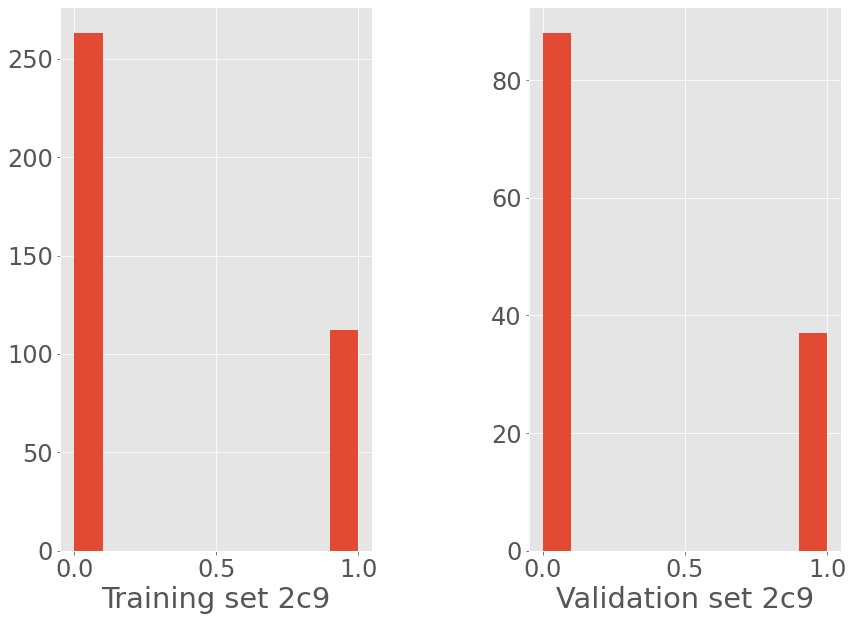

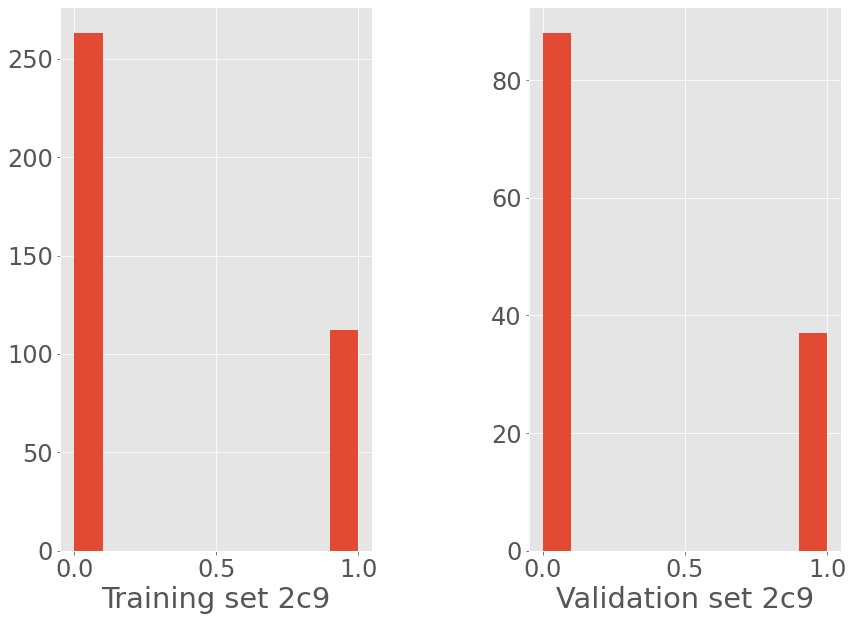

In [46]:
dataset_size = 500                  # training + validation sets
train_size = int(0.75 * dataset_size)
val_size = int(0.25 * dataset_size)
plot_distribution = True
seed=1

data_fs_fp, data_fs_des, best_feat_index_fp, best_feat_index_des = select_feat_and_get_best_feat_per_split(use_fingerprints, use_descriptors, fp_data=features_shared,
                                                                    descriptors_data=norm_descriptors_shared, labels=labels_2c9, percetile_fingerprint=60, 
                                                                    percetile_descriptors=percetile_descriptors, train_size=train_size, val_size=val_size, seed=seed, 
                                                                    plot_distribution=plot_distribution)

### 5.A)

In [30]:
def select_features(X_train, Y_train, X_test, score_func=chi2, k_best=None, percentile = None):
    """score_func=chi2 (default), mutual_info_classif"""
    if not k_best == None:
        fs = SelectKBest(score_func=score_func, k=k_best)
    elif not percentile == None:
        fs = SelectPercentile(score_func=score_func, percentile=percentile)
    else:
        print("Introduce the number of best features to be kept (`k_best`) or the percentile.")
        return
    fs.fit(X_train, Y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    
    return X_train_fs, X_test_fs, fs


def plot_score(fs, print_scores=False):
    """plot the score for all the features"""
    if print_scores:
        for i in range(len(fs.scores_)):
            print('Feature %d: %f' % (i, fs.scores_[i]))
    plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
    plt.show()
    

def get_best_features_index(fs):
    """Returns a numpy array with the indexs of the best features."""
    mask = fs.get_support()
    best_features_tup = np.where(mask == True)
    
    return best_features_tup[0] 


def get_best_features(train_data, train_labels, val_data, percentile):
    """calculates score fuction of the features and returns the best features"""
    train_data, val_data, fs = select_features(train_data, train_labels, val_data, score_func=mutual_info_classif, percentile = percentile)
    best_features = get_best_features_index(fs)
    
    assert train_data.shape[1] == val_data.shape[1]
    assert train_data.shape[1] == best_features.shape[0]
    
    return {'train_data_fs':train_data, 'val_data_fs':val_data}, best_features

def find_best_features(best_feat_split, num_feat):
    """Given a list containing the index of `best_feat_split`, we will count the most repeated `num_feat`"""
    x= collections.Counter(best_feat_split)
    return [feat for feat, count in x.most_common(num_feat)]
    

In [90]:
def generate_model(layers_dim, lr, dropout, optimizer, L2):
    """layers_dim -- [n_input, n_hid_1, ..., n_output=1]"""
    hidden_layers = []
    for i in range(1,len(layers_dim)-1): hidden_layers.extend([tf.keras.layers.Dropout(dropout)] + [tf.keras.layers.Dense(layers_dim[i], activation="relu", kernel_regularizer=tf.keras.regularizers.l2(L2))])
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(layers_dim[0], activation='relu', input_shape=(layers_dim[0],))] +
        hidden_layers + 
        [tf.keras.layers.Dense(layers_dim[-1], activation="sigmoid")])
    loss_function = tf.keras.losses.BinaryCrossentropy()
    model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]) 
    return model

def plot_confusion(predicted_values, target_values):
    cm = confusion_matrix(target_values, predicted_values >= 0.5)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt="g", cmap="Greens")
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['Inactive', 'Active']); ax.yaxis.set_ticklabels(['Inactive', 'Active'])
    plt.show()

def print_metrics(predicted_values, target_values, verbose=True):
    tn, fp, fn, tp = confusion_matrix(target_values, predicted_values >= 0.5).ravel()
    Sn = tp/(tp+fn)
    Sp = tn/(tn+fp)
    precision = tp/(tp+fp)
    ner = (Sn+Sp)/2
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    f1 = f1_score(target_values, predicted_values >= 0.5, average='binary')
    balanced_accuracy = balanced_accuracy_score(target_values, predicted_values >= 0.5, sample_weight=None, adjusted=True)
    
    if verbose:
        print(f"NER: {ner:.3f}, Sensitivity or recall: {Sn:.3f}, Specificity: {Sp:.3f}, Precision: {precision:.3f}, Correctly calssified: {accuracy:.3f}, MCC: {mcc:.3f}, F1 score: {f1:.3f}, Balanced accuracy: {balanced_accuracy:.3f}")
    return {'accuracy': accuracy, 'precision': precision, 'recall': Sn, 'specificity':Sp, 'mcc':mcc, 'ner':ner, 'f1':f1, 'balanced_accuracy':balanced_accuracy}


def plot_results_CV(MCCs_train, MCCs_val, accs_train, accs_val, recall_train, recall_val, precision_train, precision_val, F1_train, F1_val, balanced_acc_train, balanced_acc_val, test_acc, test_mcc, test_recall, test_precision, test_f1, test_balanced_acc):
    fig, ax = plt.subplots(2,3, figsize=(16,16))
    y_min = -0.1+np.nanmin([np.nanmin(balanced_acc_train), np.nanmin(balanced_acc_val), np.nanmin(test_balanced_acc), np.nanmin(F1_train), np.nanmin(F1_val), np.nanmin(test_f1), np.nanmin(accs_train), np.nanmin(accs_val),np.nanmin(test_acc), np.nanmin(MCCs_train), np.nanmin(MCCs_val), np.nanmin(test_mcc), np.nanmin(recall_train), np.nanmin(recall_val), np.nanmin(test_recall), np.nanmin(precision_train), np.nanmin(precision_val), np.nanmin(test_precision)])
    y_max = 0.1+np.nanmax([np.nanmax(balanced_acc_train), np.nanmax(balanced_acc_val), np.nanmax(test_balanced_acc),np.nanmax(F1_train), np.nanmax(F1_val), np.nanmax(test_f1), np.nanmax(accs_train), np.nanmax(accs_val), np.nanmax(test_acc), np.nanmax(MCCs_train), np.nanmax(MCCs_val), np.nanmax(test_mcc), np.nanmax(recall_train), np.nanmax(recall_val), np.nanmax(test_recall), np.nanmax(precision_train), np.nanmax(precision_val), np.nanmax(test_precision)])
    ax[0, 0].boxplot([np.array(accs_train)[~np.isnan(accs_train)], np.array(accs_val)[~np.isnan(accs_val)]], labels=["Train", "Val"])
    ax[0, 1].boxplot([np.array(recall_train)[~np.isnan(recall_train)], np.array(recall_val)[~np.isnan(recall_val)]], labels=["Train", "Val"])
    ax[0, 2].boxplot([np.array(precision_train)[~np.isnan(precision_train)], np.array(precision_val)[~np.isnan(precision_val)]], labels=["Train", "Val"]) 
    ax[1, 0].boxplot([np.array(balanced_acc_train)[~np.isnan(balanced_acc_train)], np.array(balanced_acc_val)[~np.isnan(balanced_acc_val)]], labels=["Train", "Val"])
    ax[1, 1].boxplot([np.array(F1_train)[~np.isnan(F1_train)], np.array(F1_val)[~np.isnan(F1_val)]], labels=["Train", "Val"])
    ax[1, 2].boxplot([np.array(MCCs_train)[~np.isnan(MCCs_train)], np.array(MCCs_val)[~np.isnan(MCCs_val)]], labels=["Train", "Val"])
    
    ax[0, 0].hlines(y=test_acc,linewidth=2,xmin=0, xmax=6, color='r')
    ax[0, 1].hlines(y=test_recall,linewidth=2,xmin=0, xmax=6, color='r')
    ax[0, 2].hlines(y=test_precision,linewidth=2,xmin=0, xmax=6, color='r')
    ax[1, 0].hlines(y=test_balanced_acc,linewidth=2,xmin=0, xmax=6, color='r')
    ax[1, 1].hlines(y=test_f1,linewidth=2,xmin=0, xmax=6, color='r')
    ax[1, 2].hlines(y=test_mcc,linewidth=2,xmin=0, xmax=6, color='r')
    
    ax[0, 0].set_ylim(top=y_max, bottom=y_min)
    ax[0, 1].set_ylim(top=y_max, bottom=y_min)
    ax[0, 2].set_ylim(top=y_max, bottom=y_min)
    ax[1, 0].set_ylim(top=y_max, bottom=y_min)
    ax[1, 1].set_ylim(top=y_max, bottom=y_min)
    ax[1, 2].set_ylim(top=y_max, bottom=y_min)
    ax[0, 0].set_xlim(left=0.5, right=2.5)
    ax[0, 1].set_xlim(left=0.5, right=2.5)
    ax[0, 2].set_xlim(left=0.5, right=2.5)
    ax[1, 0].set_xlim(left=0.5, right=2.5)
    ax[1, 1].set_xlim(left=0.5, right=2.5)
    ax[1, 2].set_xlim(left=0.5, right=2.5)
    ax[0, 0].set_ylabel("Accuracy")
    ax[0, 1].set_ylabel("Recall")
    ax[0, 2].set_ylabel("Precision")
    ax[1, 0].set_ylabel("Balanced Accuracy")
    ax[1, 1].set_ylabel("F1")
    ax[1, 2].set_ylabel("MCC")
    
    plt.tight_layout()
    plt.show()
    
    
def plot_results_split(MCCs_train, MCCs_val, accs_train, accs_val, recall_train, recall_val, precision_train, precision_val, F1_train, F1_val, balanced_acc_train, balanced_acc_val, test_acc, test_mcc, test_recall, test_precision, test_f1, test_balanced_acc):
    fig, ax = plt.subplots(2,3, figsize=(16,16))
    y_min = -0.1+np.nanmin([np.nanmin(balanced_acc_train), np.nanmin(balanced_acc_val), np.nanmin(test_balanced_acc), np.nanmin(F1_train), np.nanmin(F1_val), np.nanmin(test_f1), np.nanmin(accs_train), np.nanmin(accs_val),np.nanmin(test_acc), np.nanmin(MCCs_train), np.nanmin(MCCs_val), np.nanmin(test_mcc), np.nanmin(recall_train), np.nanmin(recall_val), np.nanmin(test_recall), np.nanmin(precision_train), np.nanmin(precision_val), np.nanmin(test_precision)])
    y_max = 0.1+np.nanmax([np.nanmax(balanced_acc_train), np.nanmax(balanced_acc_val), np.nanmax(test_balanced_acc),np.nanmax(F1_train), np.nanmax(F1_val), np.nanmax(test_f1), np.nanmax(accs_train), np.nanmax(accs_val), np.nanmax(test_acc), np.nanmax(MCCs_train), np.nanmax(MCCs_val), np.nanmax(test_mcc), np.nanmax(recall_train), np.nanmax(recall_val), np.nanmax(test_recall), np.nanmax(precision_train), np.nanmax(precision_val), np.nanmax(test_precision)])
    ax[0, 0].boxplot([np.array(accs_train)[~np.isnan(accs_train)], np.array(accs_val)[~np.isnan(accs_val)], np.array(test_acc)[~np.isnan(test_acc)]], labels=["Train", "Val", "Test"])
    ax[0, 1].boxplot([np.array(recall_train)[~np.isnan(recall_train)], np.array(recall_val)[~np.isnan(recall_val)], np.array(test_recall)[~np.isnan(test_recall)]], labels=["Train", "Val", "Test"])
    ax[0, 2].boxplot([np.array(precision_train)[~np.isnan(precision_train)], np.array(precision_val)[~np.isnan(precision_val)], np.array(test_precision)[~np.isnan(test_precision)]], labels=["Train", "Val", "Test"]) 
    ax[1, 0].boxplot([np.array(balanced_acc_train)[~np.isnan(balanced_acc_train)], np.array(balanced_acc_val)[~np.isnan(balanced_acc_val)], np.array(test_balanced_acc)[~np.isnan(test_balanced_acc)]], labels=["Train", "Val", "Test"])
    ax[1, 1].boxplot([np.array(F1_train)[~np.isnan(F1_train)], np.array(F1_val)[~np.isnan(F1_val)], np.array(test_f1)[~np.isnan(test_f1)]], labels=["Train", "Val", "Test"])
    ax[1, 2].boxplot([np.array(MCCs_train)[~np.isnan(MCCs_train)], np.array(MCCs_val)[~np.isnan(MCCs_val)], np.array(test_mcc)[~np.isnan(test_mcc)]], labels=["Train", "Val", "Test"])
    
    ax[0, 0].set_ylim(top=y_max, bottom=y_min)
    ax[0, 1].set_ylim(top=y_max, bottom=y_min)
    ax[0, 2].set_ylim(top=y_max, bottom=y_min)
    ax[1, 0].set_ylim(top=y_max, bottom=y_min)
    ax[1, 1].set_ylim(top=y_max, bottom=y_min)
    ax[1, 2].set_ylim(top=y_max, bottom=y_min)
    ax[0, 0].set_ylabel("Accuracy")
    ax[0, 1].set_ylabel("Recall")
    ax[0, 2].set_ylabel("Precision")
    ax[1, 0].set_ylabel("Balanced Accuracy")
    ax[1, 1].set_ylabel("F1")
    ax[1, 2].set_ylabel("MCC")
    
    plt.tight_layout()
    plt.show()

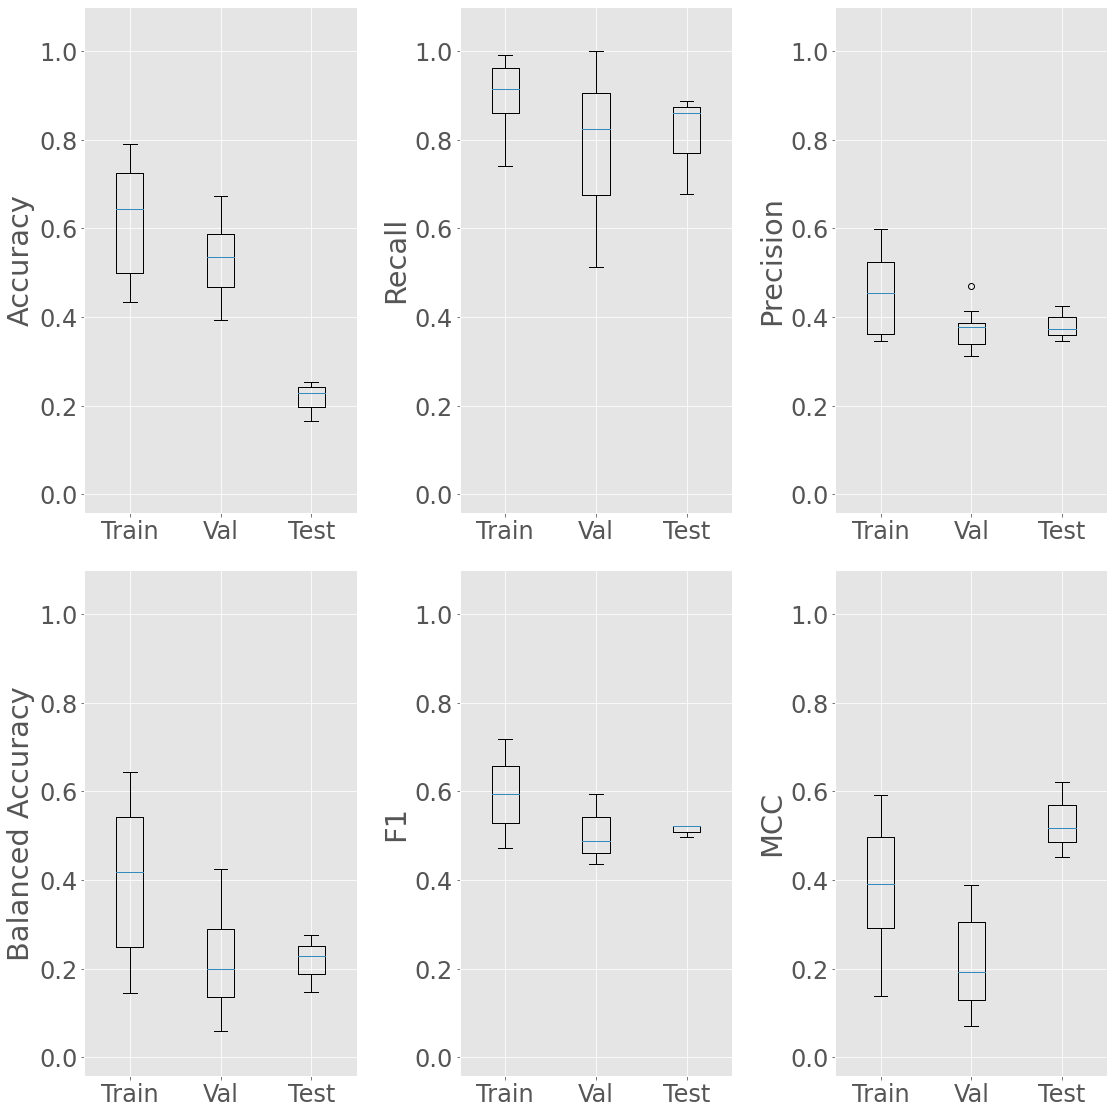

In [91]:
plot_results_split(MCCs_train_split, MCCs_val_split, accs_train_split, accs_val_split, recall_train_split, recall_val_split, precision_train_split, precision_val_split, F1_train_split, F1_val_split, balanced_acc_train_split, balanced_acc_val_split, MCCs_test_split, accs_test_split, recall_test_split, precision_test_split, F1_test_split, balanced_acc_test_split)



In [93]:
dataset_size = 500                  # training + validation sets
train_size = int(0.75 * dataset_size)
val_size = int(0.25 * dataset_size)
plot_distribution = True
seed = 1
num_train_val_splits = 15
folds = 10 # Number of folds in cross-validation

layers_dim = [30,30,30,30, 1] #excluding the input layer
lr = 0.01
dropout = 0.2
optimizer = 'sgd'
L2 = 0.001


np.random.seed(seed) # set a numpy seed
rand_num = np.random.randint(10000, size=num_train_val_splits)

--------------> STARTING SPLIT 1 <--------------
-----> Calculating with fold 1 <-----


/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[0 0 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 1 0 1 0 0
 0 1 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 0 1 1 1 0 0
 0 0 0 0 1 0 1 1 0 0 1 0 1 0 1 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 1
 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 1 0 0
 1 1 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 1 1 0 1
 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 0 1 1 0 0 1 1 0 0 0 0 1 1 0
 0 0 1 0 1 1 0 1 0 1 0 0 0 0 0 1 0 1 1 1 0 0 0 1 0 0 0 1 0 0 1 1 0 0 1 0 0
 0 0 0 0 0 1 1 0 1 1 0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 1
 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 0 1 0 1 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0
 0 0 1 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Train on 375 samples
Epoch 1/10
375/375 - 8s - loss: 0.8323 - accuracy: 0.4507 - precision_38: 0.3285 - recall_38: 0.8036
Epoch 2/10
375/375 - 0s - loss: 0.8415 - accuracy: 0.4107 - precision_38: 0.2912 - recall_38: 0.6786
Epoch 3/10
375/375 - 0s - loss: 0.8446 - accuracy: 0.4507 - precision_38: 0.3058 - recall_38: 0.6607
Epoch 4/10
375/375 - 0s - loss: 0.8315 - accuracy: 0.4880 - precision_38: 0.3182 - recall_38: 0.6250
Epoch 5/10
375/375 - 0s - loss: 0.8439 - accuracy: 0.4907 - precision_38: 0.3229 - recall_38: 0.6429
Epoch 6/10
375/375 - 1s - loss: 0.8295 - accuracy: 0.4613 - precision_38: 0.3228 - recall_38: 0.7321
Epoch 7/10
375/375 - 1s - loss: 0.8302 - accuracy: 0.5173 - precision_38: 0.3506 - recall_38: 0.7232
Epoch 8/10
375/375 - 0s - loss: 0.8298 - accuracy: 0.4960 - precision_38: 0.3158 - recall_38: 0.5893
Epoch 9/10
375/375 - 1s - loss: 0.8222 - accuracy: 0.5227 - precision_38: 0.3550 - recall_38: 0.7321
Epoch 10/10
375/375 - 0s - loss: 0.8072 - accuracy: 0.5600 - precision

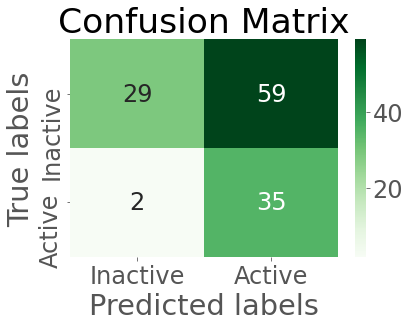

-----> Calculating with fold 2 <-----


/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[0 1 0 0 1 1 0 0 0 1 1 0 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0 1 0 0 0 0 1 0 0
 0 0 1 1 0 0 1 1 1 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1
 1 0 1 0 0 0 0 0 0 1 0 0 0 1 1 0 1 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 1 0 1 0 0 1 0 1 0 0 1 0 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 1 1 0 0 1 1 0
 0 0 0 1 0 0 0 0 1 1 0 0 1 0 1 0 1 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 1 1
 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 1 0 0 0 0 1 0 0 0 1
 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 1 0 0
 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0
 0 0 1 1 1 0 1 0 0 1 1 1 0 0 0 0 0 0 1 0 0 0 1 1 0 1 0 0 1 0 0 1 0 0 0 0 1
 0 0 1 0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Train on 375 samples
Epoch 1/10
375/375 - 3s - loss: 0.8521 - accuracy: 0.6747 - precision_39: 0.3684 - recall_39: 0.1250
Epoch 2/10
375/375 - 0s - loss: 0.8456 - accuracy: 0.6213 - precision_39: 0.3295 - recall_39: 0.2589
Epoch 3/10
375/375 - 0s - loss: 0.8365 - accuracy: 0.6373 - precision_39: 0.3537 - recall_39: 0.2589
Epoch 4/10
375/375 - 0s - loss: 0.8357 - accuracy: 0.6267 - precision_39: 0.3772 - recall_39: 0.3839
Epoch 5/10
375/375 - 0s - loss: 0.8345 - accuracy: 0.6347 - precision_39: 0.3626 - recall_39: 0.2946
Epoch 6/10
375/375 - 1s - loss: 0.8298 - accuracy: 0.6240 - precision_39: 0.3717 - recall_39: 0.3750
Epoch 7/10
375/375 - 1s - loss: 0.8294 - accuracy: 0.6480 - precision_39: 0.3889 - recall_39: 0.3125
Epoch 8/10
375/375 - 1s - loss: 0.8217 - accuracy: 0.6533 - precision_39: 0.4262 - recall_39: 0.4643
Epoch 9/10
375/375 - 1s - loss: 0.8206 - accuracy: 0.6853 - precision_39: 0.4700 - recall_39: 0.4196
Epoch 10/10
375/375 - 0s - loss: 0.8151 - accuracy: 0.6773 - precision

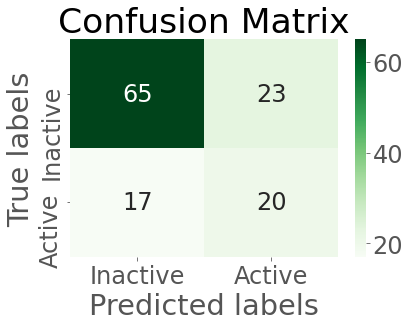

-----> Calculating with fold 3 <-----


/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[1 0 0 1 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 0 0 0 1 0 0 1 1 0
 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 1 0 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0
 1 0 0 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0
 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 0 0 0 0 0 0 0 1 1 0 0 0
 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 1 1 0 1 1 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1
 0 0 0 1 1 0 0 1 1 0 1 0 0 1 1 0 1 0 1 0 0 0 1 0 1 1 1 1 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 0 1 0 0 0 0 1 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 0 1 0 0 0
 0 0 0 0 0 0 0 1 1 1 0 0 1 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1
 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0
 0 0 0 1 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Train on 375 samples
Epoch 1/10
375/375 - 4s - loss: 0.8375 - accuracy: 0.3387 - precision_40: 0.2952 - recall_40: 0.8750
Epoch 2/10
375/375 - 0s - loss: 0.8368 - accuracy: 0.3920 - precision_40: 0.3141 - recall_40: 0.8750
Epoch 3/10
375/375 - 0s - loss: 0.8442 - accuracy: 0.3493 - precision_40: 0.2950 - recall_40: 0.8482
Epoch 4/10
375/375 - 0s - loss: 0.8398 - accuracy: 0.4107 - precision_40: 0.3114 - recall_40: 0.8036
Epoch 5/10
375/375 - 0s - loss: 0.8396 - accuracy: 0.3840 - precision_40: 0.2969 - recall_40: 0.7768
Epoch 6/10
375/375 - 1s - loss: 0.8308 - accuracy: 0.4187 - precision_40: 0.3245 - recall_40: 0.8750
Epoch 7/10
375/375 - 0s - loss: 0.8372 - accuracy: 0.4053 - precision_40: 0.3156 - recall_40: 0.8482
Epoch 8/10
375/375 - 1s - loss: 0.8367 - accuracy: 0.3707 - precision_40: 0.2905 - recall_40: 0.7679
Epoch 9/10
375/375 - 0s - loss: 0.8242 - accuracy: 0.4773 - precision_40: 0.3531 - recall_40: 0.9018
Epoch 10/10
375/375 - 0s - loss: 0.8206 - accuracy: 0.4747 - precision

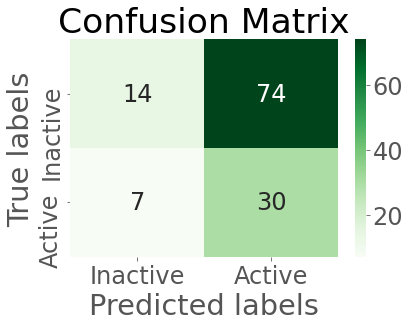

-----> Calculating with fold 4 <-----


/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0 1 0 0 1 0 0 1 0
 0 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 1 0 0 0 0 1 0 0 1 1 1 0 1 0 0 0 1 0 1 1 0
 0 0 1 0 0 0 1 0 0 0 1 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 1 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 1 0 1 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 1 0 0 1 0 0 1
 0 0 0 0 1 1 1 0 0 0 1 0 0 1 1 0 0 0 1 0 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 1 1
 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 1 0 1 1 1
 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0
 1 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0
 0 1 1 1 1 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0 1 1 1 0 1 0 1 0 0 0 0 0 1 0 0 1 0
 0 0 1 1 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Train on 375 samples
Epoch 1/10
375/375 - 3s - loss: 0.8421 - accuracy: 0.4560 - precision_41: 0.2933 - recall_41: 0.5946
Epoch 2/10
375/375 - 0s - loss: 0.8385 - accuracy: 0.4907 - precision_41: 0.3165 - recall_41: 0.6216
Epoch 3/10
375/375 - 0s - loss: 0.8446 - accuracy: 0.4747 - precision_41: 0.3063 - recall_41: 0.6126
Epoch 4/10
375/375 - 0s - loss: 0.8429 - accuracy: 0.4347 - precision_41: 0.2775 - recall_41: 0.5676
Epoch 5/10
375/375 - 0s - loss: 0.8276 - accuracy: 0.5013 - precision_41: 0.3362 - recall_41: 0.7027
Epoch 6/10
375/375 - 0s - loss: 0.8340 - accuracy: 0.5067 - precision_41: 0.3255 - recall_41: 0.6216
Epoch 7/10
375/375 - 0s - loss: 0.8214 - accuracy: 0.5147 - precision_41: 0.3408 - recall_41: 0.6847
Epoch 8/10
375/375 - 0s - loss: 0.8140 - accuracy: 0.5093 - precision_41: 0.3569 - recall_41: 0.8198
Epoch 9/10
375/375 - 0s - loss: 0.8272 - accuracy: 0.5093 - precision_41: 0.3485 - recall_41: 0.7568
Epoch 10/10
375/375 - 0s - loss: 0.8115 - accuracy: 0.5920 - precision

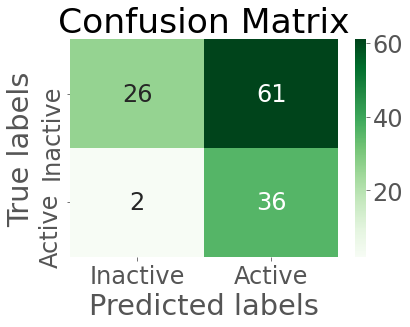

/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0 1 0 0 1 0 0 1 0
 0 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 1 0 0 0 0 1 0 0 1 1 1 0 1 0 0 0 1 0 1 1 0
 0 0 1 0 0 0 1 0 0 0 1 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 1 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 1 0 1 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 1 0 0 1 0 0 1
 0 0 0 0 1 1 1 0 0 0 1 0 0 1 1 0 0 0 1 0 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 1 1
 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 1 0 1 1 1
 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0
 1 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0
 0 1 1 1 1 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0 1 1 1 0 1 0 1 0 0 0 0 0 1 0 0 1 0
 0 0 1 1 0 1 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 0
 0 1 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 1 1 1 1 0 1 0 

Train on 500 samples
Epoch 1/10
500/500 - 4s - loss: 0.8379 - accuracy: 0.3640 - precision_42: 0.3093 - recall_42: 0.9195
Epoch 2/10
500/500 - 1s - loss: 0.8355 - accuracy: 0.3620 - precision_42: 0.3023 - recall_42: 0.8725
Epoch 3/10
500/500 - 0s - loss: 0.8282 - accuracy: 0.3580 - precision_42: 0.3018 - recall_42: 0.8792
Epoch 4/10
500/500 - 1s - loss: 0.8308 - accuracy: 0.3960 - precision_42: 0.3130 - recall_42: 0.8591
Epoch 5/10
500/500 - 1s - loss: 0.8253 - accuracy: 0.4100 - precision_42: 0.3220 - recall_42: 0.8859
Epoch 6/10
500/500 - 1s - loss: 0.8188 - accuracy: 0.4720 - precision_42: 0.3425 - recall_42: 0.8389
Epoch 7/10
500/500 - 1s - loss: 0.8196 - accuracy: 0.4240 - precision_42: 0.3249 - recall_42: 0.8658
Epoch 8/10
500/500 - 1s - loss: 0.8116 - accuracy: 0.4740 - precision_42: 0.3451 - recall_42: 0.8523
Epoch 9/10
500/500 - 1s - loss: 0.8053 - accuracy: 0.5200 - precision_42: 0.3666 - recall_42: 0.8389
Epoch 10/10
500/500 - 1s - loss: 0.7972 - accuracy: 0.5460 - precision

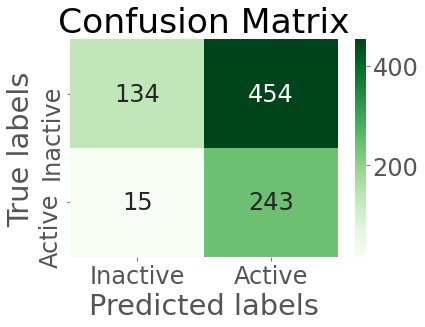

CV fold 3 of split 0 out of 3


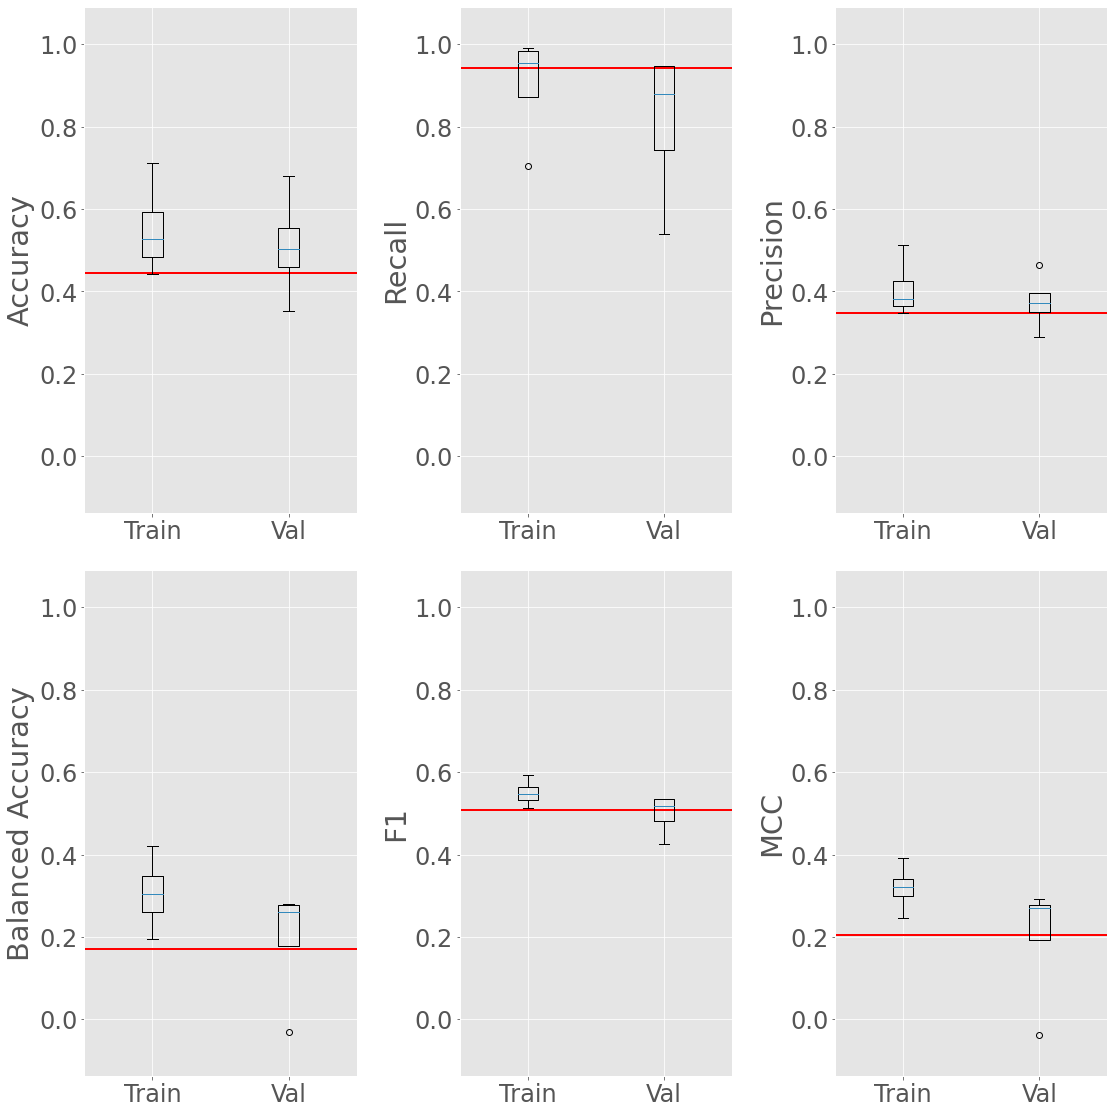

--------------> STARTING SPLIT 2 <--------------
-----> Calculating with fold 1 <-----


/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 1 0 0 1
 0 0 0 0 0 1 1 0 0 1 0 1 1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0
 0 1 0 1 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 1 1 0 1 1 0 0 0 0 1 0 0 1 1 0 0 1
 0 0 1 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 0 1 0 0 0 1 0 0 0 1 0 1 0
 0 0 0 1 0 1 1 0 0 0 0 1 0 1 1 1 0 0 1 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 1 0 1 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0
 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0
 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0
 1 0 1 0 0 1 1 1 0 0 0 1 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 0 0 1 0 0 0 1 1 0 0
 1 0 1 1 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Train on 375 samples
Epoch 1/10
375/375 - 3s - loss: 0.8366 - accuracy: 0.3093 - precision_43: 0.2874 - recall_43: 0.9009
Epoch 2/10
375/375 - 0s - loss: 0.8360 - accuracy: 0.3280 - precision_43: 0.3003 - recall_43: 0.9550
Epoch 3/10
375/375 - 0s - loss: 0.8388 - accuracy: 0.3573 - precision_43: 0.3065 - recall_43: 0.9279
Epoch 4/10
375/375 - 0s - loss: 0.8376 - accuracy: 0.3413 - precision_43: 0.2875 - recall_43: 0.8288
Epoch 5/10
375/375 - 0s - loss: 0.8340 - accuracy: 0.3440 - precision_43: 0.2910 - recall_43: 0.8468
Epoch 6/10
375/375 - 1s - loss: 0.8338 - accuracy: 0.3680 - precision_43: 0.3031 - recall_43: 0.8739
Epoch 7/10
375/375 - 0s - loss: 0.8321 - accuracy: 0.3680 - precision_43: 0.3043 - recall_43: 0.8829
Epoch 8/10
375/375 - 0s - loss: 0.8287 - accuracy: 0.3920 - precision_43: 0.3143 - recall_43: 0.8919
Epoch 9/10
375/375 - 0s - loss: 0.8189 - accuracy: 0.3947 - precision_43: 0.3187 - recall_43: 0.9189
Epoch 10/10
375/375 - 0s - loss: 0.8269 - accuracy: 0.4187 - precision

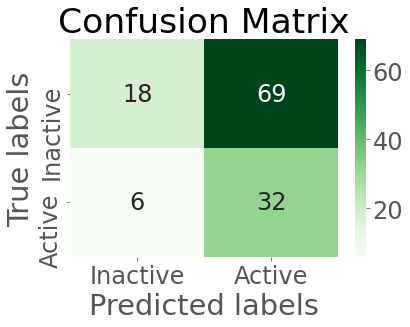

KeyboardInterrupt: 

In [92]:
MCCs_train_split, MCCs_val_split, MCCs_test_split  = [],[],[]
accs_train_split, accs_val_split, accs_test_split= [],[],[]
recall_train_split, recall_val_split, recall_test_split = [],[],[]
precision_train_split, precision_val_split, precision_test_split = [],[],[]
F1_train_split, F1_val_split, F1_test_split = [],[],[]
balanced_acc_train_split, balanced_acc_val_split, balanced_acc_test_split = [],[],[]

for split, seed in enumerate(rand_num):
    print(f"--------------> STARTING SPLIT {split+1} <--------------")
    if use_fingerprints:
        train_val_data_fp, _, train_val_labels_fp, _ = train_test_split(features_shared, labels_2c9, train_size=dataset_size, test_size=2, stratify=labels_2c9, random_state=seed)
    if use_descriptors:
        train_val_data_des, _, train_val_labels_des, _ = train_test_split(norm_descriptors_shared, labels_2c9, train_size=dataset_size, test_size=2, stratify=labels_2c9, random_state=seed)
    if use_descriptors and use_fingerprints:
        npt.assert_array_equal(train_val_labels_fp, train_val_labels_des, err_msg='Train labels do not coincide between descriptors and fingerprints.')
        assert train_val_data_fp.shape[0] == train_val_data_des.shape[0]
       
    best_features_split_fp, best_features_split_des = [], []
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)
    
    MCCs_train, MCCs_val = [],[]
    accs_train, accs_val= [],[]
    recall_train, recall_val = [],[]
    precision_train, precision_val = [],[]
    F1_train, F1_val = [],[]
    balanced_acc_train, balanced_acc_val = [],[]
    
    for i, (train_index, val_index) in enumerate(skf.split(train_val_data_fp, train_val_labels_fp)):
        if use_fingerprints:
            train_data_fp, val_data_fp = train_val_data_fp[train_index], train_val_data_fp[val_index]
            train_labels_fp, val_labels_fp = train_val_labels_fp[train_index], train_val_labels_fp[val_index]
            data_fs_fp, best_fold_fp = get_best_features(train_data_fp, train_labels_fp, val_data_fp, percetile_fingerprint)
            best_features_split_fp.extend(list(best_fold_fp))
            
            assert train_data_fp.shape[1] == val_data_fp.shape[1]
            assert train_data_fp.shape[0] == train_labels_fp.shape[0]
            assert val_data_fp.shape[0] == val_labels_fp.shape[0]
            assert best_fold_fp.shape[0] == data_fs_fp['train_data_fs'].shape[1]
                       
            if not use_descriptors: # to avoid conditional statements
                train_data, val_data = data_fs_fp['train_data_fs'], data_fs_fp['val_data_fs']
                train_labels, val_labels = train_labels_fp, val_labels_fp
        
        if use_descriptors:
            train_data_des, val_data_des = train_val_data_des[train_index], train_val_data_des[val_index]
            train_labels_des, val_labels_des = train_val_labels_des[train_index], train_val_labels_des[val_index]
            data_fs_des, best_fold_des = get_best_features(train_data_des, train_labels_des, val_data_des, percetile_descriptors)
            best_features_split_des.extend(list(best_fold_des))
            
            assert train_data_des.shape[1] == val_data_des.shape[1]
            assert train_data_des.shape[0] == train_labels_des.shape[0]
            assert val_data_des.shape[0] == val_labels_des.shape[0]
            assert best_fold_des.shape[0] == data_fs_des['train_data_fs'].shape[1]
            
            if not use_fingerprints:
                train_data, val_data = data_fs_des['train_data_fs'], data_fs_des['val_data_fs']
                train_labels, val_labels = train_labels_des, val_labels_des
                
        if use_descriptors and use_fingerprints:
            npt.assert_array_equal(train_labels_fp, train_labels_des, err_msg='Train labels do not coincide between descriptors and fingerprints.')
            npt.assert_array_equal(val_labels_fp, val_labels_des, err_msg='Validation labels do not coincide between descriptors and fingerprints.')
            assert data_fs_fp['train_data_fs'].shape[0] == data_fs_des['train_data_fs'].shape[0]
            assert data_fs_fp['val_data_fs'].shape[0] == data_fs_des['val_data_fs'].shape[0]
 
            train_labels, val_labels = train_labels_des, val_labels_des
            
            train_data = np.concatenate([data_fs_fp['train_data_fs'], data_fs_des['train_data_fs']], axis=1)
            val_data = np.concatenate([data_fs_fp['val_data_fs'], data_fs_des['val_data_fs']], axis=1)
                
        print(f"-----------> Calculating with fold {i+1} <----------")
       
        if not layers_dim[0] == train_data.shape[1]:
            layers_dim.insert(0, train_data.shape[1])
            print(type(layers_dim))

        class_weights = compute_class_weight('balanced',np.unique(train_labels), train_labels)
        class_weight = {0: class_weights[0], 1: class_weights[1]}
        
        model = generate_model(layers_dim, lr, dropout, optimizer, L2)
        # si hi ha una llista de models, es podria fer for loop de model in models
        history = model.fit(train_data, train_labels, epochs=10, verbose=2, class_weight=class_weight)#, validation_data = (val_data, val_labels))
      
        pred_train = model.predict(train_data)
        dict_train = print_metrics(pred_train, train_labels)
        train_acc, train_mcc, train_recall, train_precision, train_f1, train_balanced_acc = dict_train['accuracy'], dict_train['mcc'],  dict_train['recall'],  dict_train['precision'], dict_train['f1'], dict_train['balanced_accuracy']

        pred_val = model.predict(val_data)
        print(f"---> Validation set fold {i+1}")
        dict_val = print_metrics(pred_val, val_labels)
        val_acc, val_mcc, val_recall, val_precision, val_f1, val_balanced_acc  = dict_val['accuracy'], dict_val['mcc'],  dict_val['recall'],  dict_val['precision'], dict_val['f1'], dict_val['balanced_accuracy']
        plot_confusion(pred_val, val_labels)
        
        MCCs_train.append(train_mcc), MCCs_val.append(val_mcc)
        accs_train.append(train_acc), accs_val.append(val_acc)
        recall_train.append(train_recall), recall_val.append(val_recall)
        precision_train.append(train_precision), precision_val.append(val_precision)
        F1_train.append(train_f1), F1_val.append(val_f1)
        balanced_acc_train.append(train_balanced_acc), balanced_acc_val.append(val_balanced_acc)
    
    if use_fingerprints:
        best_feat_CV_fp = find_best_features(best_features_split_fp, data_fs_fp['train_data_fs'].shape[1])
        train_val_data_fp = np.concatenate([train_data_fp, val_data_fp], axis=0)
        
        assert train_val_data_fp.shape[0] == train_data_fp.shape[0] + val_data_fp.shape[0]
        assert train_val_data_fp.shape[1] == train_data_fp.shape[1]
        
        train_val_data_fs_fp = train_val_data_fp[:,best_feat_CV_fp]
        test_data_fp = features_only_2c9[:,best_feat_CV_fp]

        if not use_descriptors:
            labels_split = np.concatenate([train_labels_fp, val_labels_fp], axis=0)
            train_val_data_fs = train_val_data_fs_fp
            test_data = test_data_fp
            
    if use_descriptors:
        best_feat_CV_des = find_best_features(best_features_split_des, data_fs_des['train_data_fs'].shape[1])
        train_val_data_des = np.concatenate([train_data_des, val_data_des], axis=0)
        
        assert train_val_data_des.shape[0] == train_data_des.shape[0] + val_data_des.shape[0]
        assert train_val_data_des.shape[1] == train_data_des.shape[1]
        
        train_val_data_fs_des = train_val_data_des[:,best_feat_CV_des]
        test_data_des = norm_descriptors_only2c9[:,best_feat_CV_des]

        if not use_descriptors:
            labels_split = np.concatenate([train_labels_des, val_labels_des], axis=0)
            train_val_data_fs = train_val_data_fs_des
            test_data = test_data_des
            
    if use_fingerprints and use_descriptors:
        labels_split = np.concatenate([train_labels_fp, val_labels_fp], axis=0)        
        train_val_data_fs = np.concatenate([train_val_data_fs_fp, train_val_data_fs_des], axis=1)
        test_data = np.concatenate([test_data_fp, test_data_des], axis=1)
    
    class_weights = compute_class_weight('balanced',np.unique(labels_split), labels_split)
    class_weight = {0: class_weights[0], 1: class_weights[1]}
        
    model = generate_model(layers_dim, lr, dropout, optimizer, L2)
    history = model.fit(train_val_data_fs, labels_split, epochs=10, verbose=2, class_weight=class_weight)
    
    pred_test = model.predict(test_data)
    dict_test = print_metrics(pred_test, labels_testing_2c9)
    test_acc, test_mcc, test_recall, test_precision, test_f1, test_balanced_acc = dict_test['accuracy'], dict_test['mcc'],  dict_test['recall'],  dict_test['precision'], dict_test['f1'], dict_test['balanced_accuracy']
    
    print(f"----> Test set split {split+1}")
    plot_confusion(pred_test, labels_testing_2c9)
    
    print(f"CV fold {i} of split {split} out of {len(rand_num)}")
    plot_results_CV(MCCs_train, MCCs_val, accs_train, accs_val, recall_train, recall_val, precision_train, precision_val, F1_train, F1_val, balanced_acc_train, balanced_acc_val, test_acc, test_mcc, test_recall, test_precision, test_f1, test_balanced_acc)
    
    MCCs_train_split.extend(MCCs_train), MCCs_val_split.extend(MCCs_val), MCCs_test_split.append(test_mcc)
    accs_train_split.extend(accs_train), accs_val_split.extend(accs_val), accs_test_split.append(test_acc)
    recall_train_split.extend(recall_train), recall_val_split.extend(recall_val), recall_test_split.append(test_recall)
    precision_train_split.extend(precision_train), precision_val_split.extend(precision_val), precision_test_split.append(test_precision)
    F1_train_split.extend(F1_train), F1_val_split.extend(F1_val), F1_test_split.append(test_f1)
    balanced_acc_train_split.extend(balanced_acc_train), balanced_acc_val_split.extend(balanced_acc_val), balanced_acc_test_split.append(test_balanced_acc)
    
plot_results_split(MCCs_train_split, MCCs_val_split, accs_train_split, accs_val_split, recall_train_split, recall_val_split, precision_train_split, precision_val_split, F1_train_split, F1_val_split, balanced_acc_train_split, balanced_acc_val_split, MCCs_test_split, accs_test_split, recall_test_split, precision_test_split, F1_test_split, balanced_acc_test_split)
